In [ ]:
def VisualizingDataset(X_, Y_):
  X1 = X_[:, 0]
  X2 = X_[:, 1]
  for i, label in enumerate(np.unique(Y_)):
    plt.scatter(X1[Y_ == label], X2[Y_ == label])
  plt.show()

# Import library

In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests
!pip install python-dateutil

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import date, datetime
from dateutil.relativedelta import *
import joblib

Read .csv file and split it to 2 np array:

date contain the date of samples

data contain the features of samples

In [104]:
np.random.seed(69)
random_state = 69
data_path = "/content/drive/MyDrive/SE355/DoAn/Data/"

In [4]:
csv_path = data_path + "test_data.csv"
df = pd.read_csv(csv_path)
df.head()
date = df.iloc[:, 0:1].to_numpy()
data = df.iloc[:, 1:-3].to_numpy().astype(np.float32)
predict_rain = df.iloc[:, -3].to_numpy().flatten().astype(np.int8)
predict_heat = df.iloc[:, -2].to_numpy().flatten().astype(np.int8)
predict_cloud = df.iloc[:, -1].to_numpy().flatten().astype(np.int8)

# Plot label's distribution

[0 1] [20869  3779]


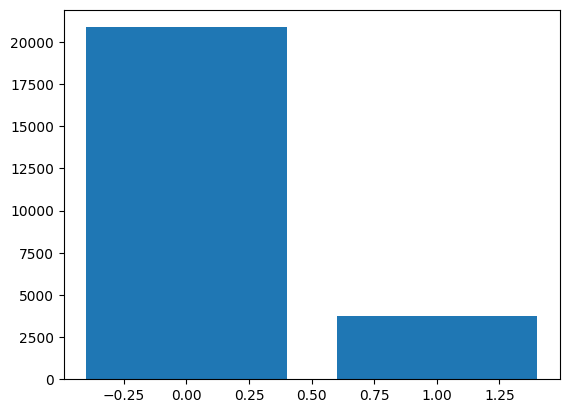

[0 1] [16643  8005]


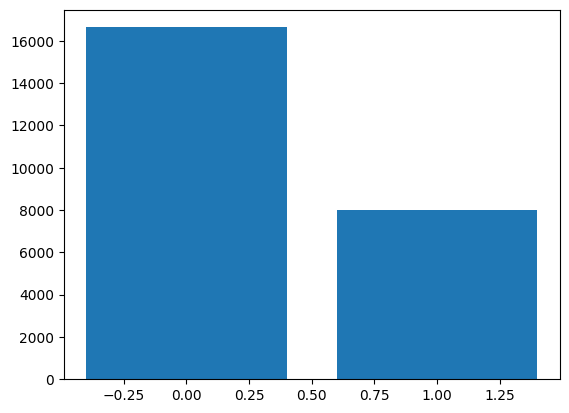

[0 1 2] [20979  2118  1551]


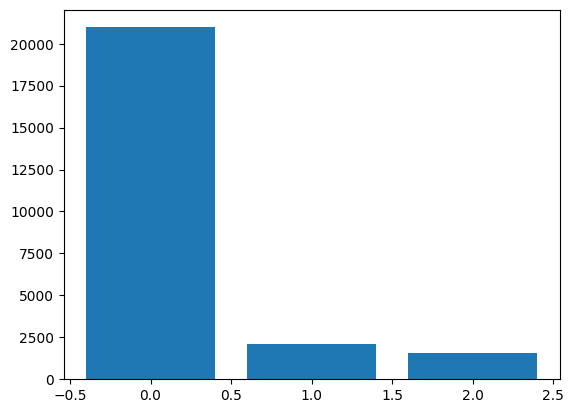

In [5]:
#labels: list of data points' label
#use to plot the number of each label
def plot_labels(labels):
  unique_labels, counts = np.unique(labels, return_counts=True)
  print(unique_labels, counts)
  plt.bar(unique_labels, counts)
  plt.show()

plot_labels(predict_rain)
plot_labels(predict_cloud)
plot_labels(predict_heat)

In [6]:
#labels: list of data points'label
#return the data points' index after undersampling
def undersampling(labels):
  unique_labels, counts = np.unique(labels, return_counts=True)
  min_size = min(counts)
  final_indices = []
  for la in unique_labels:
    indices = np.where(labels==la)
    indices = np.random.choice(indices[0], size=min_size)
    final_indices.append(indices)
  return np.array(final_indices).flatten()

# Rain predict model

In [7]:
rain_idx = undersampling(predict_rain)
rain_data, rain_labels = data[rain_idx], predict_rain[rain_idx]
rain_classes = unique_labels = np.unique(predict_rain)

[0 1] [3779 3779]


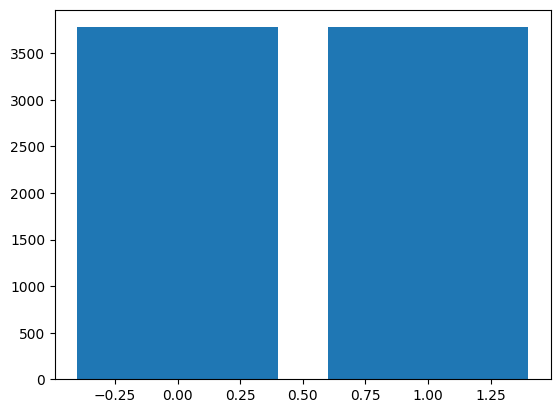

In [8]:
#data point after undersampling
plot_labels(rain_labels)

In [9]:
X_train_rain, X_test_rain, Y_train_rain, Y_test_rain = train_test_split(rain_data, rain_labels, train_size=0.8, random_state=random_state)

choose the number of component to extract with pca

In [96]:
scaler = StandardScaler()
X_train_rain_scaled = scaler.fit_transform(X_train_rain)
numbers = [10, 50, 100, 200, 300, 500, 1000, 2000, 3000, 4000]
info_ratio = []
for n in numbers:
  pca = PCA(n_components=n)
  pca.fit(X_train_rain_scaled)
  info_ratio.append(sum(pca.explained_variance_ratio_))

In [97]:
for n, ir in zip(numbers, info_ratio):
  print(n, ir)

10 0.4063113946467638
50 0.5789451275486499
100 0.6527660681167617
200 0.7330606423201971
300 0.7827521128347144
500 0.8455863306880929
1000 0.9244891733542318
2000 0.9820736175261118
3000 0.9967773187963758
4000 0.9996857522855294


info_ratio = [0.3244775803759694,
 0.5152207068167627,
 0.6274218398611993,
 0.734519753663335,
 0.8659822312474716,
 0.9456921817472903,
 0.9923077647799801,
 0.9993621863479802,
 0.999942010548267]

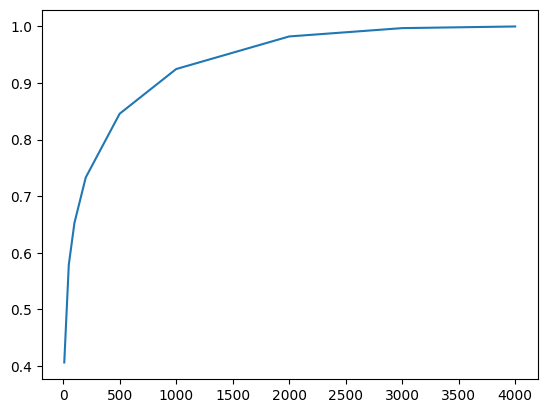

In [93]:
plt.plot(numbers, info_ratio)

In [30]:
def pca_scaler(X_train, X_test, pca_components):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled).astype(np.float32)
  X_test_pca = pca.transform(X_test_scaled).astype(np.float32)

  return X_train_pca, X_test_pca, pca, scaler

In [32]:
X_train_rain_pca, X_test_rain_pca, rain_pca, rain_sc = pca_scaler(X_train_rain, X_test_rain, 500)

In [105]:
joblib.dump(rain_pca, data_path + "rain_pca.joblib")
joblib.dump(rain_sc, data_path + "rain_sc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/rain_sc.joblib']

In [12]:
def logistic(X_train, Y_train, X_test):
  logis = LogisticRegression()
  logis.fit(X_train, Y_train)
  train_pred = logis.predict(X_train)
  test_pred = logis.predict(X_test)
  return train_pred, test_pred, logis

In [33]:
rain_train_pred, rain_test_pred, rain_logis= logistic(X_train_rain_pca, Y_train_rain, X_test_rain_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
def cm_display(true_labels, pred_labels, classes):
  cm = confusion_matrix(true_labels, pred_labels, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  plt.show()

def train_test_cm_display(train_labels, train_pred, test_labels, test_pred, classes):
  print("Train confusion matrix:")
  cm_display(train_labels, train_pred, classes)
  print("\n\nTest confusion matrix:")
  cm_display(test_labels, test_pred, classes)

Train confusion matrix:


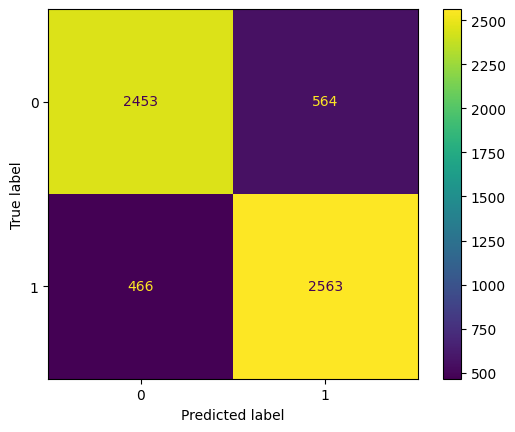



Test confusion matrix:


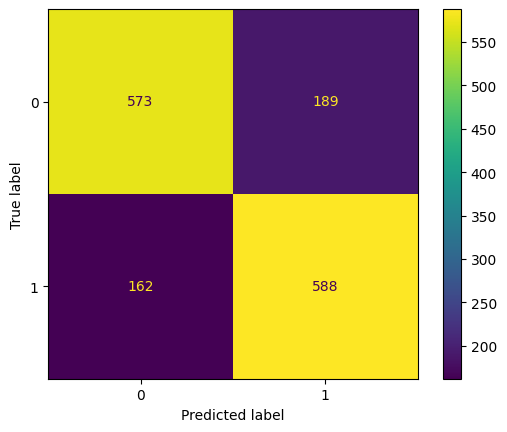

In [34]:
train_test_cm_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred, rain_classes)

In [16]:
def svc_with_kernel(kernel, X_train, Y_train, X_test):
  svc = SVC(kernel= kernel)
  svc.fit(X_train, Y_train)
  train_pred = svc.predict(X_train)
  test_pred = svc.predict(X_test)
  return train_pred, test_pred, svc

In [35]:
rain_train_pred, rain_test_pred, rain_svc = svc_with_kernel("rbf", X_train_rain_pca, Y_train_rain, X_test_rain_pca)

Train confusion matrix:


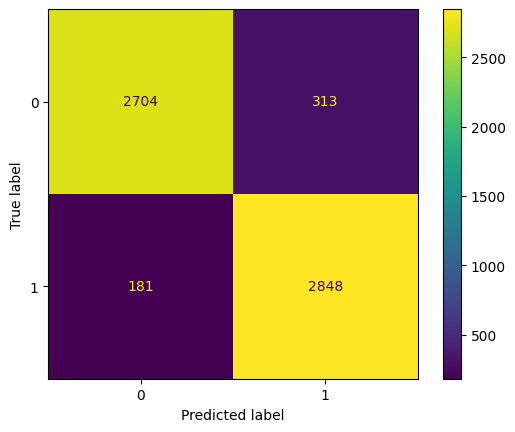



Test confusion matrix:


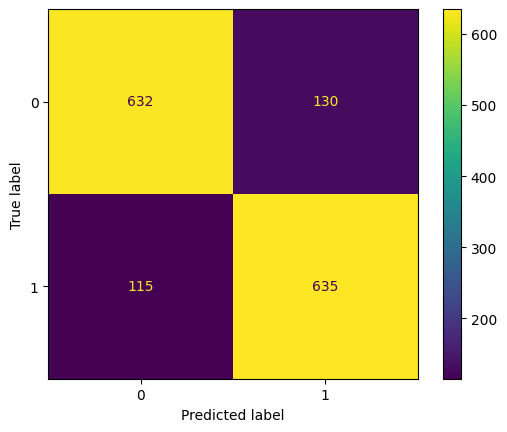

In [36]:
train_test_cm_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred, rain_classes)

In [19]:
def random_forest(X_train, Y_train, X_test, ran_estimators, ran_depth):
  ran_forest = RandomForestClassifier(n_estimators=ran_estimators, max_depth=ran_depth, random_state=random_state)
  ran_forest.fit(X_train, Y_train)
  train_pred = ran_forest.predict(X_train)
  test_pred = ran_forest.predict(X_test)
  return train_pred, test_pred, ran_forest

In [67]:
rain_train_pred, rain_test_pred, rain_rf = random_forest(X_train_rain_pca, Y_train_rain, X_test_rain_pca, 200, 22)

In [106]:
joblib.dump(rain_rf, data_path + "rain_rf.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/rain_rf.joblib']

Train confusion matrix:


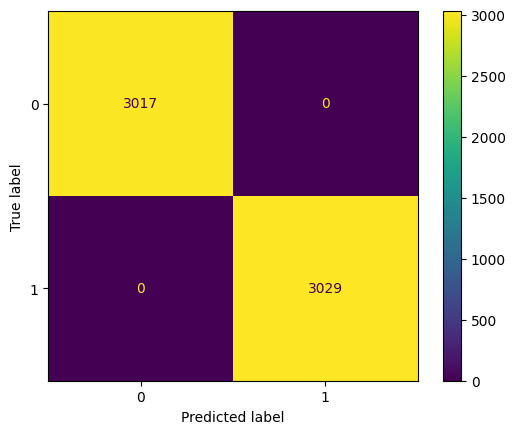



Test confusion matrix:


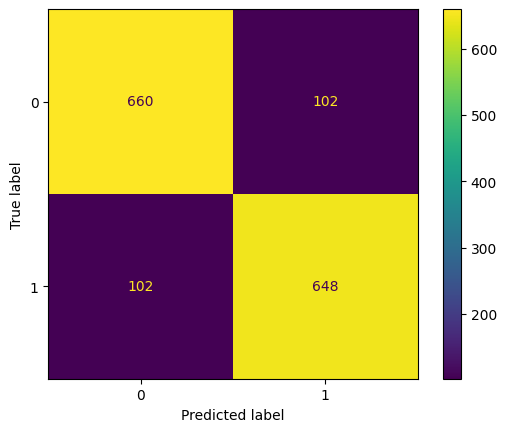

In [68]:
train_test_cm_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred, rain_classes)

# Heat predict model

In [49]:
heat_idx = undersampling(predict_heat)
heat_data, heat_labels = data[heat_idx], predict_heat[heat_idx]
heat_classes = np.unique(predict_heat)

[0 1 2] [1551 1551 1551]


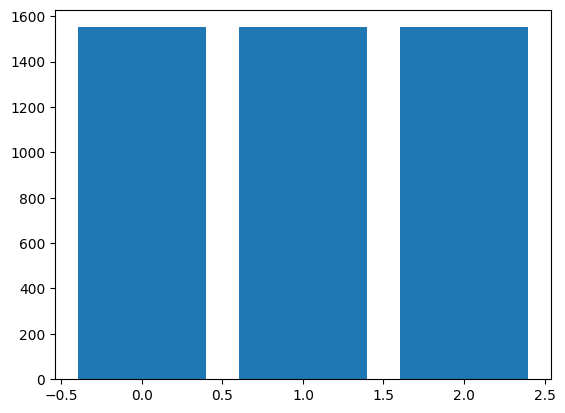

In [50]:
#data point after undersampling
plot_labels(heat_labels)

In [51]:
X_train_heat, X_test_heat, Y_train_heat, Y_test_heat = train_test_split(heat_data, heat_labels, train_size=0.8, random_state=random_state)

choose the number of component to extract with pca

In [ ]:
numbers = [10, 50, 100, 200, 500, 1000, 2000, 3000]
info_ratio = []
for n in numbers:
  pca = PCA(n_components=n)
  pca.fit(X_train_heat)
  info_ratio.append(sum(pca.explained_variance_ratio_))

In [ ]:
for n, ir in zip(numbers, info_ratio):
  print(n, ir)

[0.3483903892338276, 0.5459979176521301, 0.658795700292103, 0.7705400970298797, 0.9037456501100678, 0.9720733126960113, 0.9984183364085766, 1.0000000701933522]


info_ratio = [0.352560811676085, 0.5472714032512158, 0.6591305065667257, 0.7704329893458635, 0.903723253402859, 0.9720344025008671, 0.9984034524604795, 0.9999999988013079]

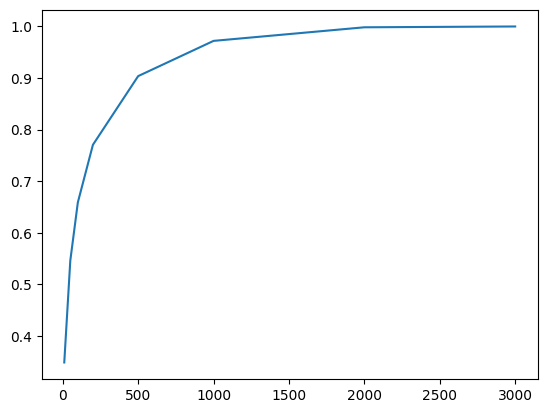

In [ ]:
plt.plot(numbers, info_ratio)

PCA & standard scaler

In [56]:
X_train_heat_pca, X_test_heat_pca, heat_pca, heat_sc = pca_scaler(X_train_heat, X_test_heat, 350)

In [107]:
joblib.dump(heat_pca, data_path + "heat_pca.joblib")
joblib.dump(heat_sc, data_path + "heat_sc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/heat_sc.joblib']

Softmax regression

In [58]:
heat_train_pred, heat_test_pred, heat_logis = logistic(X_train_heat_pca, Y_train_heat, X_test_heat_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train confusion matrix:


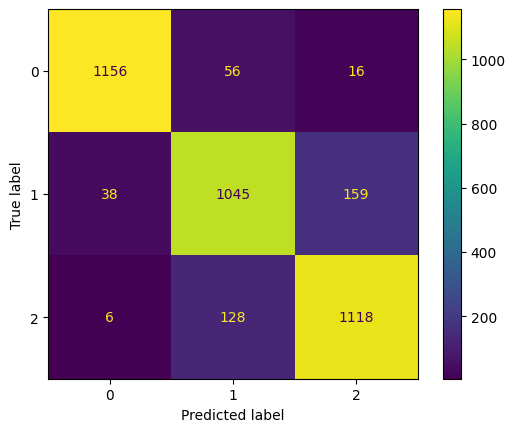



Test confusion matrix:


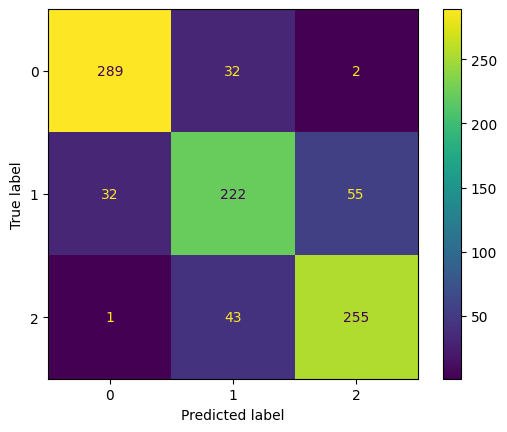

In [59]:
train_test_cm_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred, heat_classes)

SVM

In [61]:
heat_train_pred, heat_test_pred, heat_svc = svc_with_kernel("rbf", X_train_heat_pca, Y_train_heat, X_test_heat_pca)

Train confusion matrix:


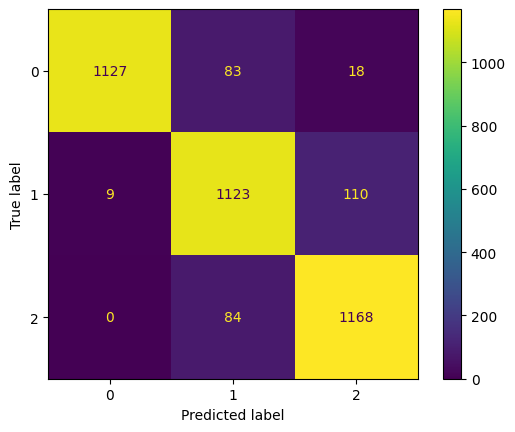



Test confusion matrix:


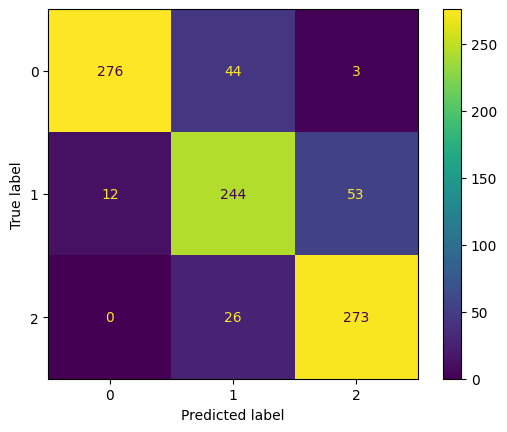

In [62]:
train_test_cm_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred, heat_classes)

In [108]:
joblib.dump(heat_svc, data_path + "heat_svc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/heat_svc.joblib']

random forest

In [63]:
heat_train_pred, heat_test_pred, heat_rf = random_forest(X_train_heat_pca, Y_train_heat, X_test_heat_pca, 170, 22)

Train confusion matrix:


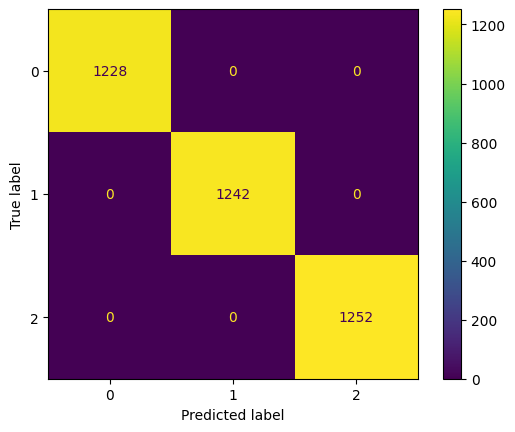



Test confusion matrix:


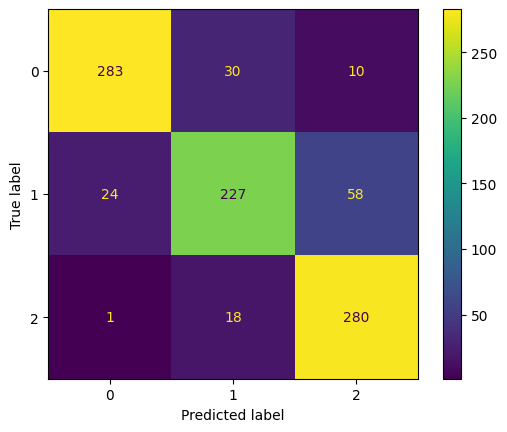

In [64]:
train_test_cm_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred, heat_classes)

# Predict cloud cover

In [77]:
cloud_idx = undersampling(predict_cloud)
cloud_data, cloud_labels = data[cloud_idx], predict_cloud[cloud_idx]
cloud_classes = np.unique(predict_cloud)

[0 1] [8005 8005]


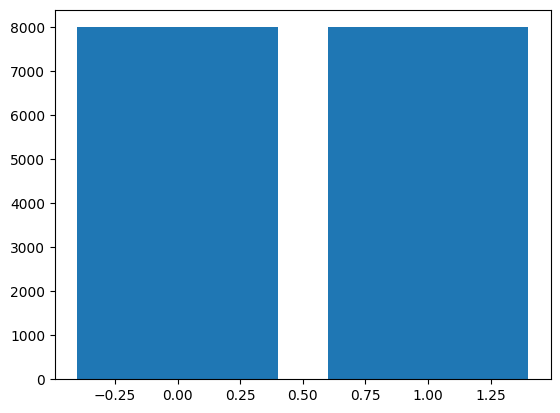

In [78]:
#data point after undersampling
plot_labels(cloud_labels)

In [79]:
X_train_cloud, X_test_cloud, Y_train_cloud, Y_test_cloud = train_test_split(cloud_data, cloud_labels, train_size=0.8, random_state=random_state)

choose the number of component to extract with pca

In [ ]:
numbers = [10, 50, 100, 200, 500, 1000, 2000, 3000, 4000]
info_ratio = []
for n in numbers:
  pca = PCA(n_components=n)
  pca.fit(X_train_cloud)
  info_ratio.append(sum(pca.explained_variance_ratio_))

In [ ]:
print(info_ratio)

[0.32827975507825613, 0.5211429537739605, 0.6339239132357761, 0.7425934176426381, 0.8749012955231592, 0.9519915169366868, 0.9938116899293163, 0.9995263105461163, 0.9999621277957189]


info_ratio = [0.32557917200028896, 0.519470531726256, 0.6327587414998561, 0.7413287366507575, 0.8741259582457133, 0.9517678496995359, 0.993821409812881, 0.9995279015609526, 0.9999620209099831]


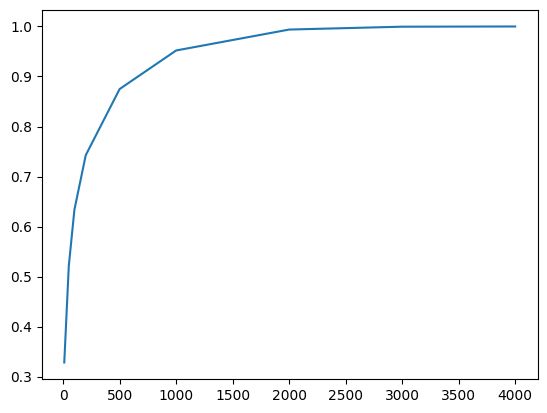

In [ ]:
plt.plot(numbers, info_ratio)

In [80]:
X_train_cloud_pca, X_test_cloud_pca, cloud_pca, cloud_sc = pca_scaler(X_train_cloud, X_test_cloud, 500)

In [109]:
joblib.dump(cloud_pca, data_path + "cloud_pca.joblib")
joblib.dump(cloud_sc, data_path + "cloud_sc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/cloud_sc.joblib']

Softmax regression

In [82]:
cloud_train_pred, cloud_test_pred, cloud_logis = logistic(X_train_cloud_pca, Y_train_cloud, X_test_cloud_pca)

Train confusion matrix:


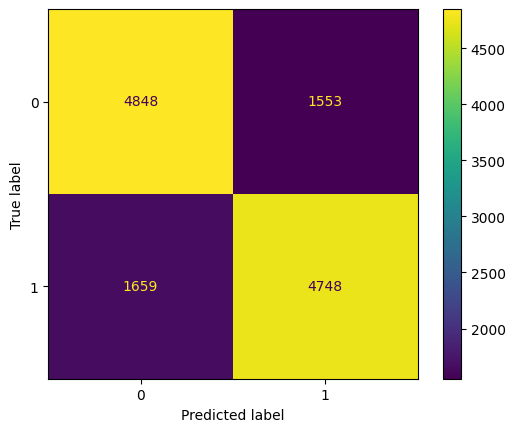



Test confusion matrix:


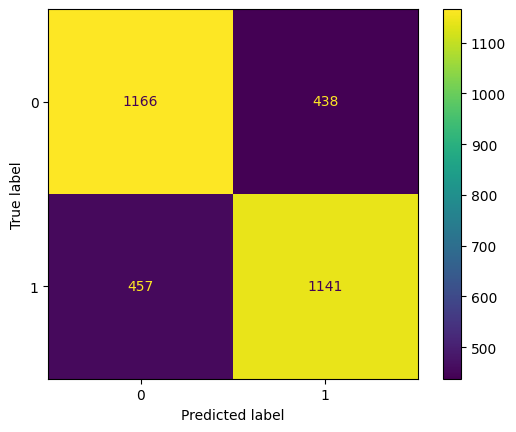

In [83]:
train_test_cm_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred, cloud_classes)

SVM

In [84]:
cloud_train_pred, cloud_test_pred, cloud_svc = svc_with_kernel("rbf", X_train_cloud_pca, Y_train_cloud, X_test_cloud_pca)

Train confusion matrix:


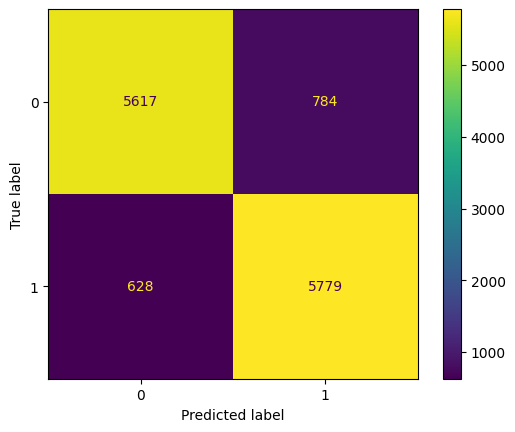



Test confusion matrix:


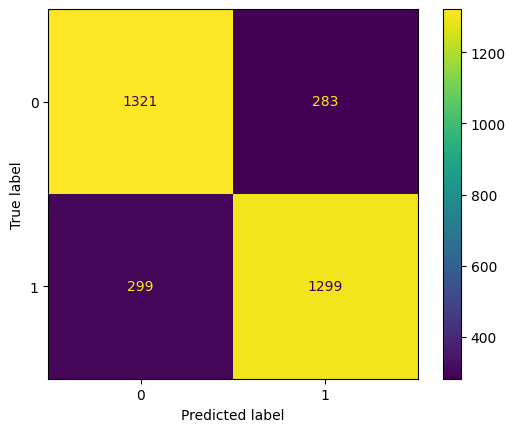

In [85]:
train_test_cm_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred, cloud_classes)

Random forest

In [88]:
cloud_train_pred, cloud_test_pred, cloud_rf = random_forest(X_train_cloud_pca, Y_train_cloud, X_test_cloud_pca, 200, 22)

In [110]:
joblib.dump(cloud_rf, data_path + "cloud_rf.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/cloud_rf.joblib']

Train confusion matrix:


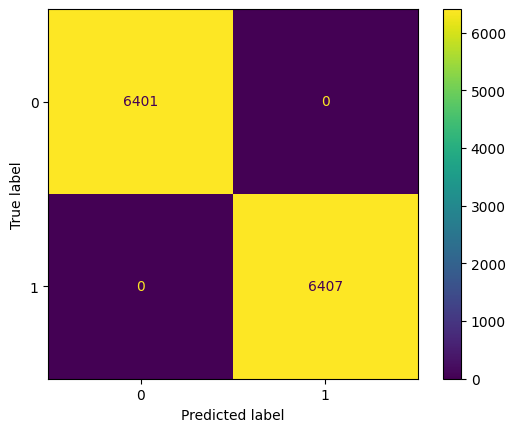



Test confusion matrix:


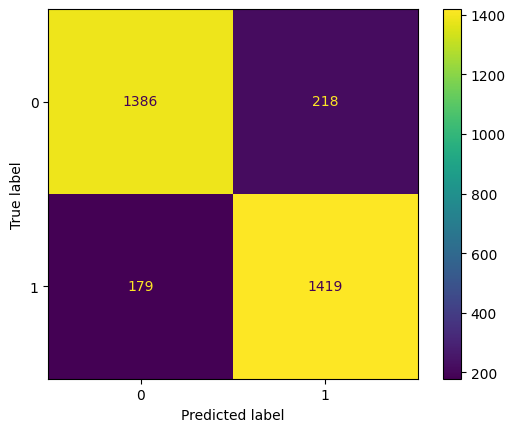

In [89]:
train_test_cm_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred, cloud_classes)

# Demo

In [69]:
def get_weather_feats(lat, long, start_date, end_date):
	# Setup the Open-Meteo API client with cache and retry on error
  cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
  retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
  openmeteo = openmeteo_requests.Client(session = retry_session)
  hourly_feats = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature",
                  "rain", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
                  "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"]
  # Make sure all required weather variables are listed here
  # The order of variables in hourly or daily is important to assign them correctly below
  url = "https://archive-api.open-meteo.com/v1/archive"
  params = {
    "latitude": lat,
    "longitude": long,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": hourly_feats,
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]
  # print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
  # print(f"Elevation {response.Elevation()} m asl")
  # print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  # print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s"),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  for i, feat in enumerate(hourly_feats):
    hourly_data[feat] = hourly.Variables(i).ValuesAsNumpy()

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  return hourly_dataframe

In [70]:
q1_lat, q1_long = 10.7807, 106.6994
current_date = datetime.today() - relativedelta(days=2)
current_date = current_date.isoformat().split("T")[0]
print(current_date)

2023-12-22


In [ ]:
hourly_df = get_weather_feats(q1_lat, q1_long, current_date, current_date)
hourly_df.head(24)

In [71]:
def get_last_year_week(date):
  date_list = []
  seven_days = 7*24
  deltas = [-seven_days, -1, 1, seven_days]
  date_milestone = []
  for delta in deltas:
    milestone = date + relativedelta(years= -1, hours= delta)
    date_milestone.append(str(milestone))
  return date_milestone

def get_last_week(date):
  week_far = date + relativedelta(days= -2)
  week_near = date + relativedelta(days= -8)
  return week_near, week_far

def get_week_data(data, time_near, time_far):
  pos1 = np.flatnonzero(data["date"].to_numpy() == time_near)[0]
  pos2 = np.flatnonzero(data["date"].to_numpy() == time_far)[0]
  return data.iloc[pos1:pos2+1, 1:].to_numpy(copy=True).flatten()

def build_data(date, lat, long):
  week_near, week_far = get_last_week(date)
  last_week_df = get_weather_feats(lat, long, week_near.date(), week_far.date())
  last_week_feats = last_week_df.iloc[:, 1:].to_numpy().flatten()

  ly_near_milestone = date + relativedelta(years= -1, hours= -(24*7))
  ly_far_milestone = date + relativedelta(years= -1, hours= 23 + 24*7)
  last_year_df = get_weather_feats(lat, long, ly_near_milestone.date(),
                                  ly_far_milestone.date())
  data = []
  hours = []
  last_year_df["date"] = last_year_df["date"].astype(str)
  for i in range(0, 24):
    hour = date + relativedelta(hours= i)
    ly_ms = get_last_year_week(hour)
    ly_before_feats = get_week_data(last_year_df, ly_ms[0], ly_ms[1])
    ly_after_feats = get_week_data(last_year_df, ly_ms[2], ly_ms[3])
    features = np.concatenate([last_week_feats, ly_before_feats, ly_after_feats])
    data.append(features)
    hours.append(str(hour))
  return np.array(data), hours

today = datetime.fromisoformat(str(datetime.now().date()))
today_data, hours = build_data(today, q1_lat, q1_long)

In [113]:
def load_model(data_path):
  rain_sc = joblib.load(data_path + "rain_sc.joblib")
  rain_pca = joblib.load(data_path + "rain_pca.joblib")
  rain_rf = joblib.load(data_path + "rain_rf.joblib")

  heat_sc = joblib.load(data_path + "heat_sc.joblib")
  heat_pca = joblib.load(data_path + "heat_pca.joblib")
  heat_svc = joblib.load(data_path + "heat_svc.joblib")

  cloud_sc = joblib.load(data_path + "cloud_sc.joblib")
  cloud_pca = joblib.load(data_path + "cloud_pca.joblib")
  cloud_rf = joblib.load(data_path + "cloud_rf.joblib")

  return (rain_sc, rain_pca, rain_rf,
          heat_sc, heat_pca, heat_svc,
          cloud_sc, cloud_pca, cloud_rf)

In [115]:
def weather_forecast(data_path, today_data):
  (rain_sc, rain_pca, rain_rf,
  heat_sc, heat_pca, heat_svc,
  cloud_sc, cloud_pca, cloud_rf) = load_model(data_path)

  data_scaled = rain_sc.transform(today_data)
  data_pca = rain_pca.transform(data_scaled)
  rain_pred = rain_rf.predict(data_pca)

  data_scaled = heat_sc.transform(today_data)
  data_pca = heat_pca.transform(data_scaled)
  heat_pred = heat_svc.predict(data_pca)

  data_scaled = cloud_sc.transform(today_data)
  data_pca = cloud_pca.transform(data_scaled)
  cloud_pred = cloud_rf.predict(data_pca)
  return [rain_pred, heat_pred, cloud_pred]

predict = weather_forecast(data_path, today_data)

In [117]:
print(predict)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8)]


In [118]:
rain_status = ["Không mưa", "Mưa"]
heat_status = ["Mát", "Nóng", "Nóng gay gắt"]
cloud_status = ["Ít mây", "Nhiều mây"]
for i in range(0, 24):
  print(hours[i], ":")
  print(rain_status[predict[0][i]])
  print(heat_status[predict[1][i]])
  print(cloud_status[predict[2][i]])

2023-12-24 00:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 01:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 02:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 03:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 04:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 05:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 06:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 07:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 08:00:00 :
Không mưa
Mát
Nhiều mây
2023-12-24 09:00:00 :
Không mưa
Mát
Nhiều mây
2023-12-24 10:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 11:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 12:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 13:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 14:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 15:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 16:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 17:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 18:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 19:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 20:00:00 :
Không mưa
Mát
Ít mây
2023-12-24 21:00:00 :
Không mưa
Mát
Ít mây
2023